TODO Poner la cobertura de genes (muy pocos representados en el ME model)  
TODO Poner cómo se hizo la conversión de Replciacion en equivalentes de genoma

# Energy from the ME model

### Table of Contents
* [Import and colors](#Colors)
* [ATP consumption per reaction](#ATP_reaction)
* [ATP consumption per gene](#ATP_gene)
* [ATP consumption (Strains)](#ATP_strains)
    * [Plot](#Plot_ATP_strains)
* [ATP consumption analysis for each process (ME model)](#ATP_analysis)
    * [Replication](#Replication_ATP)
    * [Transcription](#Transcription_ATP)
    * [UPF](#UPF_ATP)
* [ATP consumption analysis for each process (ME model and proteomic data) ](#ATP_analysis_prot)
* [Comparison between literature data and our analysis](#Comparison)





# Imports and colors <a class="anchor" id="Colors"></a>

In [1]:
import re
import pickle
import numpy as np
import pandas as pd
from scipy import stats

# Own modules for analysis
from energy_analisis import (get_energy_consumption_production, energy_per_model,
                             get_energy_per_gene, get_energy_ME_proteome)
from plot_energy import plot_ME_energy, plot_glc_ox_atp, plot_energy_ME_proteome

In [2]:
# load solved ME model
with open('../files/models/iJL1678b_solver.pickle', 'rb') as f:
    me = pickle.load(f)

# ATP consumption per reaction <a class="anchor" id="ATP_reaction"></a>

We use the ME model to see the ATP consumption per all the reactions in the model 

In [3]:
# Get the consumption and production of energy per reaction
reactions_energy_consumption,reactions_energy_production = get_energy_consumption_production(me)

In [4]:
# Energy consumption
energy_consumption = pd.DataFrame.from_dict(reactions_energy_consumption).set_index('Reactions')
energy_consumption.head()

,Type,ATP,Used
Reactions,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,-3.988197e-09
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,-2.039023e-04
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,-5.661036e-12
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,-1.200694e-07
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,-3.812990e-06


In [5]:
# Energy Production
energy_production = pd.DataFrame.from_dict(reactions_energy_production).set_index('Reactions')
energy_production.head()

,Type,ATP,Used
Reactions,,,
ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2,MetabolicReaction,1.0,52.367990
NDPK1_FWD_ADENYL-KIN-MONOMER_mod_mg2,MetabolicReaction,-1.0,-9.991650
PGK_REV_PGK-CPLX,MetabolicReaction,1.0,12.566816
PPK2r_REV_PPK-CPLX,MetabolicReaction,1.0,0.000097
SUCOAS_REV_SUCCCOASYN,MetabolicReaction,1.0,3.955319


In [6]:
total_produced = energy_production.sum().Used
total_produced

58.8985714173988

In [7]:
# Save file
energy_consumption.to_pickle('../files/energy/energy_per_reaction.pickle')

In [8]:
with open('../files/energy/energy_per_reaction.pickle', 'rb') as f:
    energy_consumption = pickle.load(f)

<div class="alert alert-block alert-info">
<b>ATP consumption per reaction</b> We obtained how much ATP is consumed per reaction according to the ME model (ATP column) and that value multiplied by the reaction flux (Used column). We also extracted how that reaction was clasified in the ME model (Transcription Reaction, Metabolic Reaction, etc).</div>

In [9]:
energy_consumption.loc[:,'Used'] = abs(energy_consumption.Used) # Absolute value
energy_consumption.head()

,Type,ATP,Used
Reactions,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,3.988197e-09
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,2.039023e-04
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,5.661036e-12
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,1.200694e-07
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,3.812990e-06


# ATP consumption per gene <a class="anchor" id="ATP_gene"></a>

Now we want to know which genes are related to those reactions and extract the ATP consumption of all the reactions related to each gene

In [10]:
# Get ATP consumption per gene
total = get_energy_per_gene(energy_consumption, me)

In [11]:
Energia_total_ME = pd.DataFrame(total.items(), columns=['Bnumber', 'Value'])
Energia_total_ME = Energia_total_ME.sort_values(by='Value',ascending=False).reset_index()
Energia_total_ME = Energia_total_ME.loc[:,['Bnumber','Value']]

In [12]:
Energia_total_ME.to_pickle('../files/energy/energy_per_gene.pickle')

<div class="alert alert-block alert-info">
<b>ATP consumption per gene </b> Now we have the ATP consumption for each gene present in the ME model</div>

In [13]:
Energia_total_ME.head()

,Bnumber,Value
0,b3256,22.337696
1,dummy,1.671482
2,b2752,0.977113
3,b1677,0.232208
4,b0727,0.194296


# ATP consumption (Strains) <a class="anchor" id="ATP_strains"></a>

After calculating the ATP consumption per gene, we wanted to know the ATP consumption of the genes that were deleted on the minimized strains would represent

In [14]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
strains = names_MG1655+names_W3110

genes_finales = {}

# Get the deleted genes per strain
for strain in strains:
    genes_finales[strain] = pd.read_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv')
    genes_finales[strain] = genes_finales[strain].drop(columns= 'Unnamed: 0')

#### Per gene

In [15]:
# ATP consumption per gene of each strain
strain_energy_per_gen={}
for strain in strains:
    genes = genes_finales[strain].Bnumber
    strain_energy_per_gen[strain] = Energia_total_ME.loc[Energia_total_ME.Bnumber.isin(genes)]

#### Per strain

In [16]:
# Total ATP consumption per strain (in mmol*gDW-1*h-1 and in percentage)
strain_energy_total={}
for strain in strains:
    strain_energy_total[strain] = [strain_energy_per_gen[strain].Value.sum()]
    
strain_energy_total_per={}
for strain in strains:
    strain_energy_total_per[strain] = [(strain_energy_per_gen[strain].Value.sum()*100)/(total_produced)]

In [17]:
consumo = pd.DataFrame.from_dict(strain_energy_total)
consumo = consumo.T.rename(columns={0:'Energy'}).T
consumo_per =  pd.DataFrame.from_dict(strain_energy_total_per)
consumo_per = consumo_per.T.rename(columns={0:'Energy'}).T

<div class="alert alert-block alert-info">
<b>ATP consumption</b> Now we have the calculated ATP consumption that would be represented by the genes that were deleted </div>

In [18]:
consumo

,Δ16,MS56,MDS69,MDS42,MDS12,DGF298,DGF327,MGF02,MGF01
Energy,0.788286,0.172213,0.167337,0.163238,0.163234,0.174018,0.168425,0.004769,0.003504


In [19]:
relevant_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

<div class="alert alert-block alert-success">
<b>ATP consumption per strain plot </b> 
</div>

 <a class="anchor" id="Plot_ATP_strains"></a>




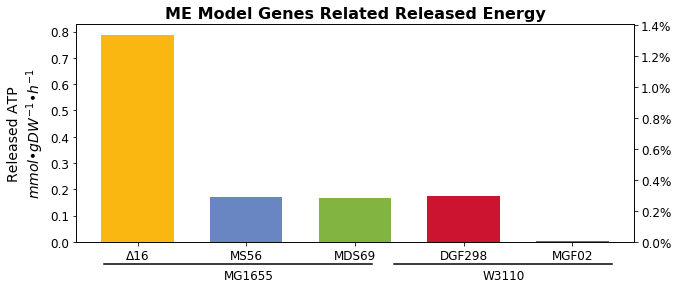

In [20]:
plot_ME_energy(relevant_strains,consumo, consumo_per )

# ATP consumption analysis for each process  (ME model)<a class="anchor" id="ATP_analysis"></a>

As not all the genes are represented in the ME model, to take into account all the genes we can make an estimate of how much ATP is consumed in the replication process, transcription process and protein production process per Mb in average so we can apply that to all the genes

## Replication  <a class="anchor" id="Replication_ATP"></a>

We analyze the simulations from the ME model were we increased the DNA percentage of the cell. More details of the simulation in [Replication_cost.ipynb](https://github.com/utrillalab/proteomeVSgenome/blob/main/src/Energy_simulations/Replication_cost.ipynb)

In [21]:
# How much the DNA percentage in the cell will be increased
replication_models = ['1', '1.125', '1.25', '1.5']  # 1 means the percentage stays the same, 1.5 means 50% increase
models = {}

for rep_model in replication_models:
    with open('../files/models/DNA_per'+rep_model+'.pickle', 'rb') as f:
        models[rep_model] = pickle.load(f)

In [22]:
models

{'1': <MEModel iJL1678b-ME at 0x7f92ac0c6d30>,
 '1.125': <MEModel iJL1678b-ME at 0x7f9289321080>,
 '1.25': <MEModel iJL1678b-ME at 0x7f9289339198>,
 '1.5': <MEModel iJL1678b-ME at 0x7f9289321e48>}

In [23]:
# ATP consumption calculation per model 
consumption_me, p = energy_per_model(models)

In [24]:
consumption_me

{'me1': 48.83228748371048,
 'me1.125': 48.842039251079456,
 'me1.25': 48.85179103734148,
 'me1.5': 48.87129454230218}

<div class="alert alert-block alert-success">
<b>Replication process ATP consumption plot</b> 
</div>





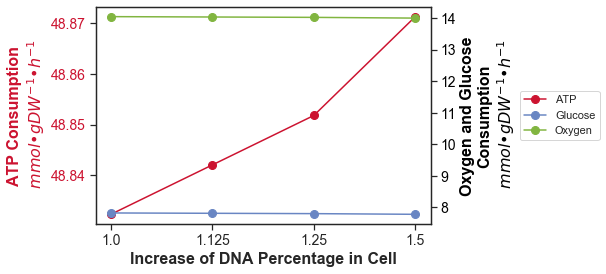

In [25]:
plot_glc_ox_atp(consumption_me, models, tipo='Replication')

In [26]:
valores = [1, 1.125, 1.25, 1.5]
new_valores = np.array(valores)

equivalentes_genoma = new_valores*1.63 
equivalentes_genoma
bp = equivalentes_genoma*4641652/1.63
Mb = bp*1/(1*10**6)

In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Mb, list(consumption_me.values()))

<div class="alert alert-block alert-info">
<b>Replication process ATP cost:</b> We have a replication cost of  $$\frac{0.017\;mmol\;ATP}{gDW\cdot h} \;per\;Mb$$  </div>

In [28]:
replication_cost = slope
replication_cost

0.016807404105231676

## Transcription  <a class="anchor" id="Transcription_ATP"></a>

We analyze the simulations from the ME model were we increased the number of genes being transcripted but not trasnlated in the model. More details of the simulation in [Transcription_cost.ipynb](https://github.com/utrillalab/proteomeVSgenome/blob/main/src/Energy_simulations/Transcription_cost.ipynb)

In [29]:
# Number of genes added being transcripted but not translated
extra_genes = ['230', '460', '690', '920']
extra_genes_int = [int(genes) for genes in extra_genes]
transcription_models = {}
solutions = []

for gene in extra_genes:
    with open('../files/models/AumGenes_GLC_OX_'+gene+'.pickle', 'rb') as f:
        model = pickle.load(f)
        model.name = gene
        transcription_models[gene]= model
        solutions.append(model.solution.f)
    


### Global

ATP consumption of all the fluxes

In [30]:
consumption_me_trn, consumption_me_group, p = energy_per_model(transcription_models, group=True)

In [31]:
consumption_me_trn

{'me230': 51.77917211144516,
 'me460': 54.70214019240527,
 'me690': 57.625234172573656,
 'me920': 60.54832815274208}

<div class="alert alert-block alert-success">
<b>Transcription ATP consumption in all the fluxes plot </b> 
</div>





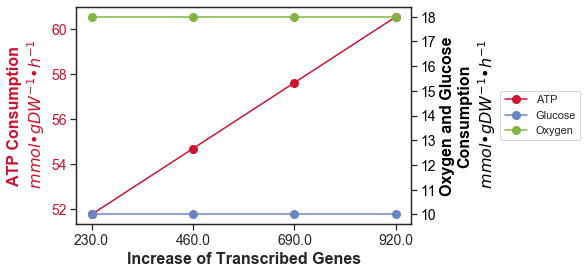

In [32]:
plot_glc_ox_atp(consumption_me_trn, transcription_models, tipo='Transcription')

In [33]:
slope, intercept, r_value, p_value, std_err = stats.linregress(extra_genes_int, [consumption_me_trn['me'+genes] for genes in extra_genes])
costo_Mb = (10**6 )* slope / 900
costo_Mb

14.12104449471456

<div class="alert alert-block alert-info">
<b>Transcription ATP cost in all fluxes</b> As we are interested in the changes of ATP consumption of transcription, instead of taking this cost, we only then checked the ATP consumption on the transcription fluxes . But the global cost was   $$\frac{14.12\;mmol\;ATP}{gDW\cdot h} \;per\;Mb$$</div>

In [34]:
transcription_gcost =  costo_Mb

### Transcription fluxes

In [35]:
consumption_transR = {}
for genes in consumption_me_group:
    consumption_transR[genes] = consumption_me_group[genes].loc['TranscriptionReaction']

In [36]:
consumption_transR

{'me230': 0.20475514375843407,
 'me460': 0.2641392705772779,
 'me690': 0.32352583607409535,
 'me920': 0.382912401570913}

<div class="alert alert-block alert-success">
<b>Transcription ATP consumption in transcription fluxes plot </b> 
</div>





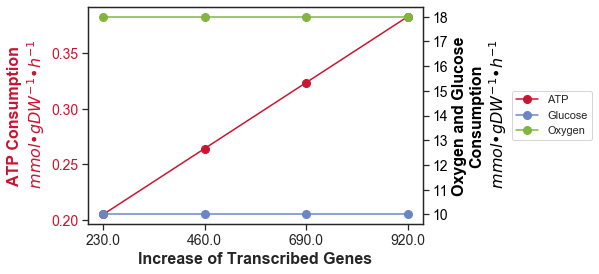

In [37]:
plot_glc_ox_atp(consumption_transR, transcription_models, tipo='Transcription')

In [38]:
slope_2, intercept_2, r_value, p_value, std_err = stats.linregress(extra_genes_int,
                                                                   [consumption_transR['me'+genes] for genes in extra_genes])

costo_Mb_2 = (10**6 )* slope_2 / 900
costo_Mb_2

0.28688808644166874

<div class="alert alert-block alert-info">
<b>Transcription ATP cost in transcription fluxes</b> We have the ATP cost  on the transcription fluxes of increasing the genes that are being transcripted but not translated. $$\frac{0.29\;mmol\;ATP}{gDW\cdot h} \;per\;Mb$$</div>

In [39]:
transcription_tcost = costo_Mb_2
transcription_tcost

0.28688808644166874

## UPF <a class="anchor" id="UPF_ATP"></a>

We analyze the protein production cost by making simulations in the ME were we changed the UPF. The objective function was ATPM. More details of the simulation in [UPF_cost.ipynb](https://github.com/utrillalab/proteomeVSgenome/blob/main/src/Energy_simulations/UPF_cost.ipynb)

In [40]:
# Changes in the UPF values 
valores= ['0.24', '0.27', '0.3', '0.33', '0.36']
modelos_ox_glc = {}

for upf in valores:
    name = 'me'+upf.split('.')[1]
    with open('../files/models/ATPM_UPF_OX_GLC'+name+'.pickle', 'rb') as f:
        modelos_ox_glc[upf] = pickle.load(f)


In [41]:
modelos_ox_glc

{'0.24': <MEModel iJL1678b-ME at 0x7f923e1c8a20>,
 '0.27': <MEModel iJL1678b-ME at 0x7f923e19da90>,
 '0.3': <MEModel iJL1678b-ME at 0x7f929ec53048>,
 '0.33': <MEModel iJL1678b-ME at 0x7f929ec53518>,
 '0.36': <MEModel iJL1678b-ME at 0x7f91c8541198>}

### Whole

In [42]:
consumption_me_ox_glc, production_me_ox_glc = energy_per_model(modelos_ox_glc)

<div class="alert alert-block alert-success">
<b>UPF ATP cost from all fluxes plot </b> 
</div>





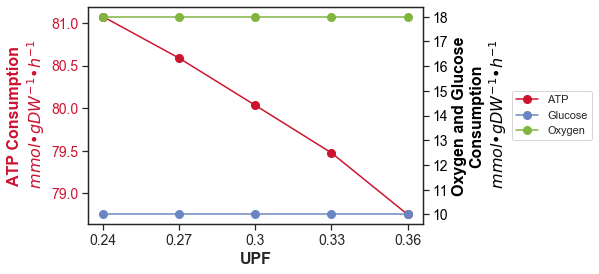

In [43]:
plot_glc_ox_atp(consumption_me_ox_glc, modelos_ox_glc, tipo='UPF')

### Cellular consumption

As the ATPM function was the objective, to see how much ATP was actually consumed by the cell we needed to substract the ATP from the ATPM reaction from the total ATP consumption 

In [44]:
# Get the total ATP consumption, the ATPM ATP consumption and substract that to get the celular consumption
suma_atpm_consum_ox = pd.DataFrame({'me'+modelo:[consumption_me_ox_glc['me'+modelo],
                                            modelos_ox_glc[modelo].reactions.get_by_id('ATPM').x,
                                            consumption_me_ox_glc['me'+modelo] - modelos_ox_glc[modelo].reactions.get_by_id('ATPM').x] for modelo in modelos_ox_glc})

suma_atpm_consum_ox = suma_atpm_consum_ox.T
suma_atpm_consum_ox.columns=['Total_Consumption','ATPM','Celular_Consumption']

In [45]:
suma_atpm_consum_ox.sort_index()

,Total_Consumption,ATPM,Celular_Consumption
me0.24,81.073349,33.221185,47.852164
me0.27,80.586732,32.352479,48.234253
me0.3,80.033724,31.365251,48.668473
me0.33,79.476319,30.236040,49.240279
me0.36,78.754471,28.937432,49.817039


In [46]:
cel_con = suma_atpm_consum_ox['Celular_Consumption']

In [47]:
cel_con

me0.24    47.852164
me0.27    48.234253
me0.3     48.668473
me0.33    49.240279
me0.36    49.817039
Name: Celular_Consumption, dtype: float64

<div class="alert alert-block alert-success">
<b>UPF ATP cellular consumption plot </b> 
</div>





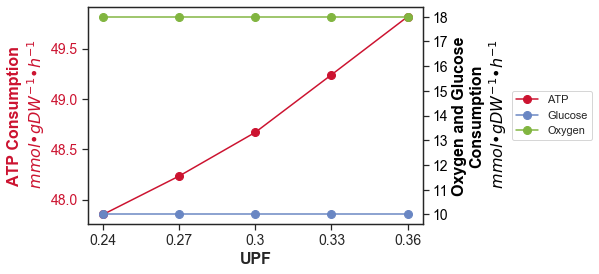

In [48]:
plot_glc_ox_atp(cel_con.to_dict(), modelos_ox_glc, tipo='UPF')

In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress([0.24,0.27,0.3,0.33,0.36],list(cel_con.values))



slope por cada 1 de UPF o por cada 100 %, 0.01 de UPF  = 1% proteoma

In [50]:
slope*0.01

0.16452584583939214

<div class="alert alert-block alert-info">
<b>UPF ATP cost</b> Now we know the UPF ATP cost excluding the ATPM flux, we calculated that the cost of the protein production as: $$\frac{0.16\;mmol\;ATP}{gDW\cdot h} \;per\;1\%\;of\;UPF$$</div>

In [51]:
scientific_notation = "{:.2e}".format(slope*0.01)

print(scientific_notation)

1.65e-01


In [52]:
upf_cost = slope*0.01
upf_cost
 

0.16452584583939214

# ATP consumption analysis for each process (ME model and proteomic data)<a class="anchor" id="ATP_analysis_prot"></a>

Now that we have all the costs for the processes, and we also have proteomic data from [Schmidt, Alexander, et al. 2016](https://www.nature.com/articles/nbt.3418) we can estimate how much energy is represented by the deleted genes even if they are not in the ME model  

In [53]:
proteomic_data = pd.read_excel("../files/proteome_Schmidt/Proteomic_data_fg.xlsx") 



In [54]:
print(replication_cost)
print(transcription_gcost )
print(transcription_tcost )
print(upf_cost )




0.016807404105231676
14.12104449471456
0.28688808644166874
0.16452584583939214


In [55]:
# Calculate de cost of each process represented by the deleted genes by each strain
costos_calculados = get_energy_ME_proteome(strains, genes_finales, proteomic_data, 
                                           replication_cost, transcription_tcost, upf_cost )

In [56]:
costos_calculados = pd.DataFrame(costos_calculados)

In [57]:
costos_calculados.loc[['Replication', 'Transcription', 'UPF'],:]

,Δ16,MS56,MDS69,MDS42,MDS12,DGF298,DGF327,MGF02,MGF01
Replication,0.014900,0.014593,0.014495,0.010143,0.005486,0.025221,0.020973,0.017605,0.015525
Transcription,0.254328,0.249094,0.247409,0.173130,0.093647,0.430499,0.357992,0.300503,0.265002
UPF,1.382076,0.663690,0.404314,0.272571,0.119124,0.986304,0.905680,0.699351,0.660157


<div class="alert alert-block alert-success">
<b>ATP consumption analysis per process per strain plot </b> 
</div>





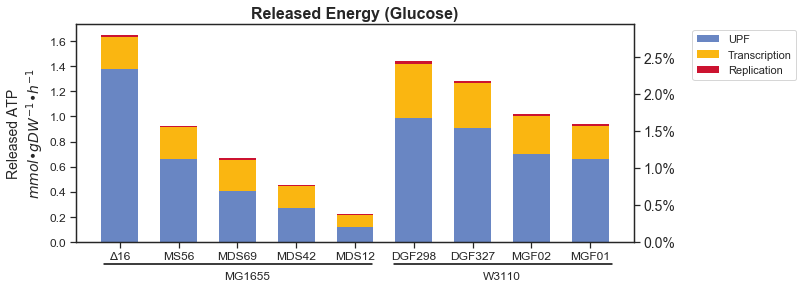

In [58]:
plot_energy_ME_proteome(strains, costos_calculados, ['UPF','Transcription','Replication'], medio='Glucose',
                 normalizado=False, eng=True, identifier='Multipanel_Energy_prot'  ) 

#### Normalized

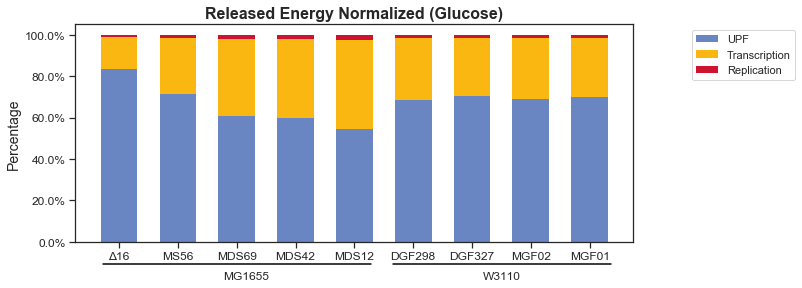

In [59]:
plot_energy_ME_proteome(strains, costos_calculados, ['UPF','Transcription','Replication'], medio='Glucose',
                 normalizado=True, eng=True, identifier='Multipanel_Energy_prot'  ) 

# Comparison between literature data and our analysis <a class="anchor" id="Comparison"></a>

To compare our results we used data from  [Lynch, Michael, and Georgi K. Marinov. 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1514974112) were they describe the costs in ATP terms of a gene at the DNA, RNA and protein levels in E. coli. 

In [60]:
# Our calculations 
print(replication_cost) # ATP per Mb
print(transcription_tcost) # ATP per M b
print(upf_cost ) # ATP per 1% of UPF

0.016807404105231676
0.28688808644166874
0.16452584583939214


We need the UPF cost in terms of Mb, so we calculate the UPF cost in Mb in a average gene (~1kb) in the glucose condition

In [61]:
mean_prot_glc = proteomic_data.Glucosa.mean() /proteomic_data.Glucosa.sum()*100
mean_prot_glc

0.04242681374628766

In [62]:
upf_cost_kb = upf_cost *  mean_prot_glc # ATP per 999b gene
upf_cost_Mb = upf_cost_kb * 1*10**6 / 999


In [63]:
upf_cost_Mb

6.987294712590917

In [64]:
costs_ME = {'Replication':[replication_cost], 'Transcription':[transcription_tcost], 'UPF':[upf_cost_Mb] }

In [65]:
costs_ME = pd.DataFrame.from_dict(costs_ME, orient='index', columns=['ME units'])

As the units in Lynch and Marinov are in ATP hydrolisis, we convert our units to match those by taking into account the E. coli cell dry weight and the growth rate of our simulations

ME model units $$\frac{x\;mmol }{gDW\cdot h}$$

To get the units equivalent to Lynch & Marinov (ATP Hydrolysis)


$$ \frac{x\;mmol }{gDW\cdot h}\;\cdot\;\frac{1\;mol}{1000\;mmol}\;\cdot\;\frac{6.022x10^{23}\;atoms}{1\;mol}\;\cdot\;\frac{ 3x10^{-13}gDW}{0.69\;h^{-1}}$$


In [66]:
mol_mmol = 1*10**3  # 1 mol = 1000 mmol.
avogadro =  (6.022*10**23 )  # Avogadro number
cell_DW = 3*10**(-13)  # E. coli cell dry weight 3 x 10-13 g (https://ecmdb.ca/e_coli_stats)
mu =  0.69 # Growth rate  (h-1)
Mb_b = 1*10**6 # 1 Mb = 1 000 000 bp 

In [67]:
costs_ME.loc[:,'ME (ATP hydr) Mb'] = costs_ME.loc[:, 'ME units'] /mol_mmol *  avogadro * cell_DW / mu

As Lynch & Marinov reported the costs for a 950b gene, we also make that conversion 

In [68]:
# For 950 Mb
costs_ME.loc[:,'ME (ATP hydr) 950b'] =  costs_ME.loc[:,'ME (ATP hydr) Mb'] * 950 / Mb_b

In [69]:
costs_ME.loc[:,'Lynch & Marinov 950b'] = [136000,150000,4114000]

<div class="alert alert-block alert-info">
<b>ATP costs comparisons</b> Now we have same units to compare the Lynch & marinov costs ("Lynch & Marinov 950b" column) with our calculations ("ME (ATP hydr) 950b" column)</div>

In [70]:
costs_ME

,ME units,ME (ATP hydr) Mb,ME (ATP hydr) 950b,Lynch & Marinov 950b
Replication,0.016807,4.400617e+06,4.180586e+03,136000
Transcription,0.286888,7.511479e+07,7.135905e+04,150000
UPF,6.987295,1.829456e+09,1.737983e+06,4114000


In [71]:
costs_ME.to_csv('../files/energy/Costs_L&M_ME.csv')